In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

def plot_cm(gt,pred,le):
    cm = confusion_matrix(gt, pred, labels=le.classes_)
    fig = plt.figure(figsize=(6, 5), dpi=120)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(values_format="d")
    plt.title("ROI-level Confusion Matrix (OOF)")
    plt.tight_layout()
    plt.show()
def pr_table(y_true, y_pred, class_names):
    p, r, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=range(len(class_names)), zero_division=0
    )
    return pd.DataFrame({
        "class": class_names,
        "precision": p,
        "recall": r,
        "f1": f1,
        "support": sup
    })

def plot_pr_grouped(df_pr, title=None, ylim=(0,1)):
    idx = np.arange(len(df_pr))
    width = 0.38

    fig, ax = plt.subplots(figsize=(8, 3.8), dpi=120)
    ax.bar(idx - width/2, df_pr["precision"].values, width, label="Precision")
    ax.bar(idx + width/2, df_pr["recall"].values,    width, label="Recall")
    ax.set_xticks(idx)
    ax.set_xticklabels(df_pr["class"].values, rotation=45, ha="right")
    ax.set_ylim(*ylim)
    ax.set_ylabel("Score")
    if title: ax.set_title(title)
    ax.legend()
    ax.grid(axis="y", linestyle=":", alpha=0.4)
    plt.tight_layout()
    plt.show()
# # Simple bar plots for precision/recall
# for metric in ["precision","recall"]:
#     plt.figure(figsize=(7,3), dpi=120)
#     ax = per_class[metric].plot(kind="bar")
#     plt.ylabel(metric.capitalize())
#     plt.xlabel("Class")
#     plt.title(f"Per-class {metric.capitalize()} (OOF)")
#     plt.xticks(rotation=45, ha="right")
#     plt.tight_layout()
#     plt.show()


0.22635135135135134
0.494949494949495
0.494949494949495


<Figure size 720x600 with 0 Axes>

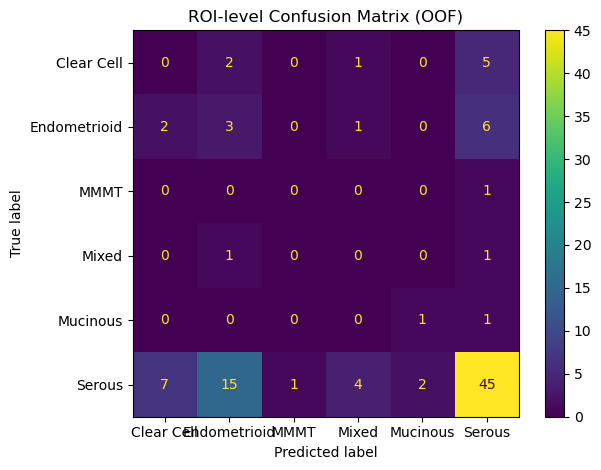

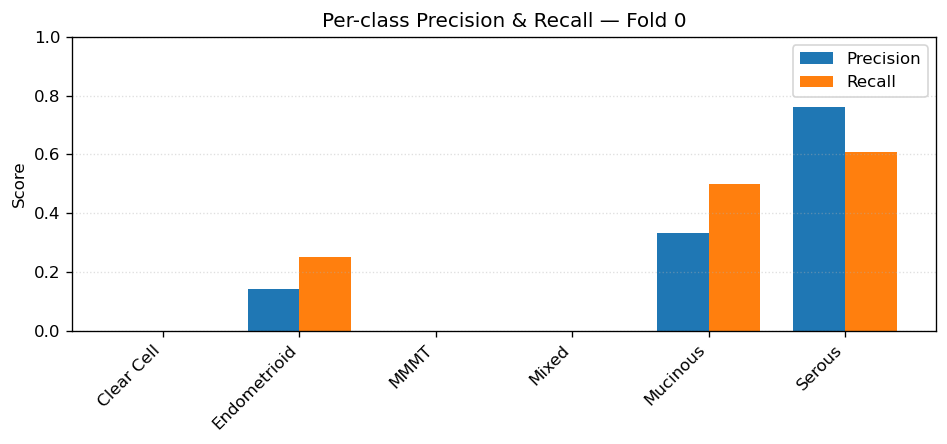

0.26045688545688545
0.45918367346938777
0.4591836734693877


<Figure size 720x600 with 0 Axes>

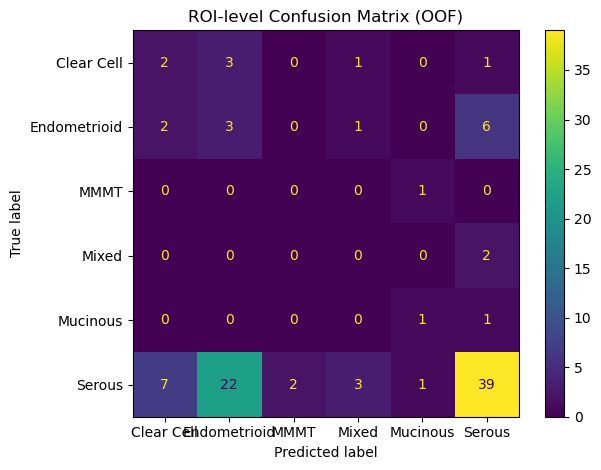

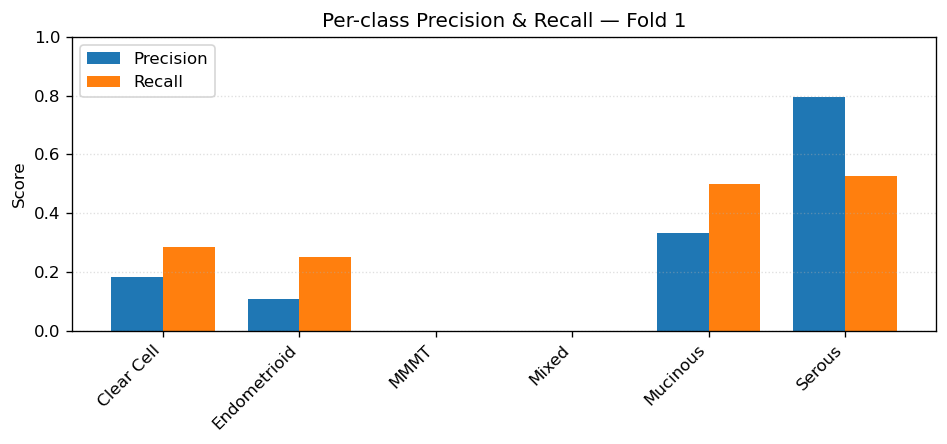

0.17912861491628615
0.5102040816326531
0.5102040816326531


<Figure size 720x600 with 0 Axes>

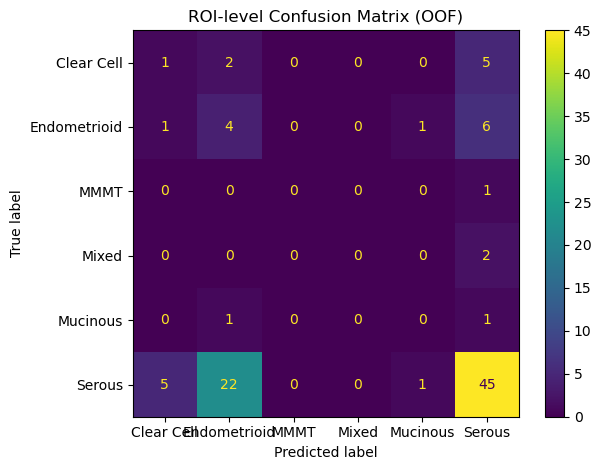

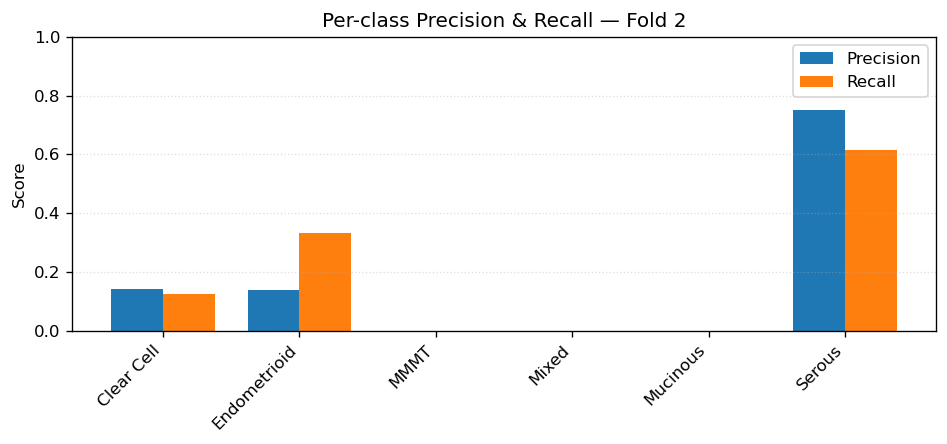

In [54]:
# --- Reproduce CV folds, GT/preds, and plots ---
from pathlib import Path
import pickle, yaml
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,balanced_accuracy_score,accuracy_score, recall_score
)
import matplotlib.pyplot as plt

# 1) POINT THIS TO YOUR run's --outdir
RUN_DIR = Path("/projects/wangc/m344313/OVTMA_project/output/demo")
EVAL_DIR = RUN_DIR / "evaluate" / "roi_supervised_best"

# 2) Load saved ROI embedding, ROI order, trained fold classifiers
E = loadmat(str(EVAL_DIR / "roi_embedding.mat"))["E"]           # (n_roi, d)
group_ids = pickle.load(open(EVAL_DIR / "group_ids.pkl", "rb")) # len n_roi, ROI keys aligned to rows of E
clf_list  = pickle.load(open(EVAL_DIR / "best_clf_list.pkl", "rb"))

# 3) Load labels & diagnostics (to match encodings/splits)
df = pd.read_csv(RUN_DIR / "dataframes" / "df.csv")
diag = yaml.safe_load(open(EVAL_DIR / "best_roi_supervision.yaml"))["diagnostics"]
classes_str = diag["classes"]                     # label names in the fit
n_splits_eff = int(diag["n_splits_effective"])

# ROI-level labels in the embedding order
roi_lab = (pd.DataFrame({"ROI": group_ids})
           .merge(df[["ROI","roi_label"]].drop_duplicates(), on="ROI", how="left"))
assert not roi_lab["roi_label"].isna().any(), "Missing ROI labels."

# Use the same label mapping as training (LabelEncoder equivalent)
# Ensure order matches classes_str from training
le = LabelEncoder(); le.classes_ = np.array(classes_str, dtype=object)
y = le.transform(roi_lab["roi_label"].values)

# Optional grouping (if present in df)
groups = None
use_groups = False
if "Subject" in df.columns:
    gmap = df[["ROI","Subject"]].drop_duplicates()
    groups = pd.DataFrame({"ROI": group_ids}).merge(gmap, on="ROI", how="left")["Subject"].values
    # Heuristic: if unique groups >= n_splits and matches clf_count, use GroupKFold
    use_groups = pd.Series(groups).notna().all() and pd.Series(groups).nunique() >= n_splits_eff

# 4) Rebuild the splitter exactly like training
if use_groups:
    splitter = GroupKFold(n_splits=n_splits_eff)
    split_iter = list(splitter.split(E, y, groups=groups))
else:
    # Training used shuffle=True, random_state=cfg.random_state (defaults to 42)
    try:
        run_cfg = yaml.safe_load(open(RUN_DIR / "config" / "resolved_config.yaml"))["roi_supervision"]
        rs = int(run_cfg.get("random_state", 42))
    except Exception:
        rs = 42
    splitter = StratifiedKFold(n_splits=n_splits_eff, shuffle=True, random_state=rs)
    split_iter = list(splitter.split(E, y))

assert len(split_iter) == len(clf_list), "Mismatch: fold count vs saved classifiers."

# 5) Collect per-fold predictions
oof_rows = []
for fold_idx, ((tr, va), clf) in enumerate(zip(split_iter, clf_list)):
    y_true = y[va]
    y_pred = clf.predict(E[va])
    proba  = clf.predict_proba(E[va])  # columns correspond to le.classes_
    for i, idx in enumerate(va):
        row = {
            "fold": fold_idx,
            "ROI": group_ids[idx],
            "y_true": le.classes_[y_true[i]],
            "y_pred": le.classes_[y_pred[i]],
        }
        # add per-class probabilities (nice to have)
        for ci, cname in enumerate(le.classes_):
            row[f"proba_{cname}"] = float(proba[i, ci])
        oof_rows.append(row)
oof = pd.DataFrame(oof_rows)
class_to_idx = {c:i for i,c in enumerate(le.classes_)}


for fold_id, g in oof.groupby("fold", sort=True):
    print(balanced_accuracy_score(g["y_true"], g["y_pred"]))
    print(accuracy_score(g["y_true"], g["y_pred"]))
    print(recall_score(g["y_true"], g["y_pred"],average="weighted"))
    plot_cm(g["y_true"], g["y_pred"], le)
    y_true_idx_f = g["y_true"].map(class_to_idx).values
    y_pred_idx_f = g["y_pred"].map(class_to_idx).values
    pr_f = pr_table(y_true_idx_f, y_pred_idx_f, class_names=le.classes_)

    plot_pr_grouped(pr_f, title=f"Per-class Precision & Recall — Fold {fold_id}", ylim=(0,1))


,class,precision,recall,f1,support
0,Clear Cell,0.592593,0.695652,0.640000,23
1,Endometrioid,0.394366,0.777778,0.523364,36
2,MMMT,0.666667,0.666667,0.666667,3
3,Mixed,0.800000,0.666667,0.727273,6
4,Mucinous,0.666667,0.666667,0.666667,6
5,Serous,0.918033,0.760181,0.831683,221


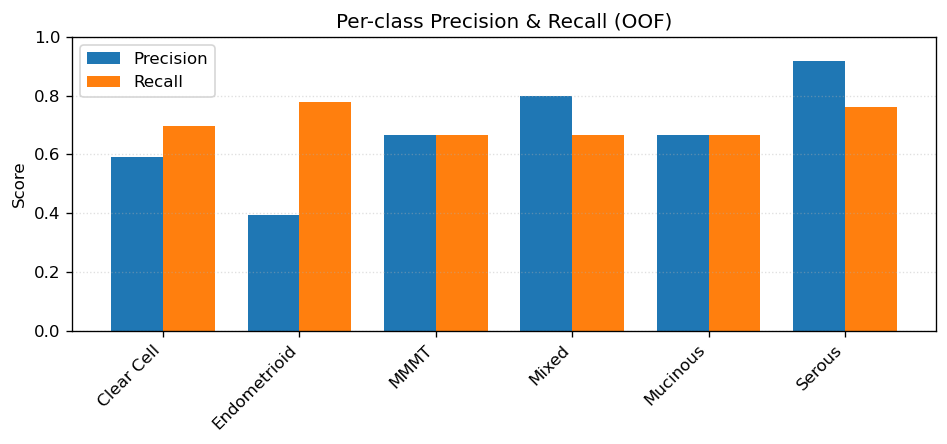

ValueError: If using all scalar values, you must pass an index

In [ ]:




# ---- 1) Overall (OOF) precision/recall in ONE plot ----
# Map string labels to indices per le.classes_ to align with training order
class_to_idx = {c:i for i,c in enumerate(le.classes_)}
y_true_idx = oof["y_true"].map(class_to_idx).values
y_pred_idx = oof["y_pred"].map(class_to_idx).values

overall_pr = pr_table(y_true_idx, y_pred_idx, class_names=le.classes_)
display(overall_pr[["class","precision","recall","f1","support"]])
plot_pr_grouped(overall_pr, title="Per-class Precision & Recall (OOF)", ylim=(0,1))

# ---- 2) Fold-by-fold precision/recall (one plot per fold) ----
for fold_id, g in oof.groupby("fold", sort=True):
    y_true_idx_f = g["y_true"].map(class_to_idx).values
    y_pred_idx_f = g["y_pred"].map(class_to_idx).values
    pr_f = pr_table(y_true_idx_f, y_pred_idx_f, class_names=le.classes_)
    display(pd.DataFrame({"fold": fold_id}).join(pr_f[["class","precision","recall","f1","support"]]))
    plot_pr_grouped(pr_f, title=f"Per-class Precision & Recall — Fold {fold_id}", ylim=(0,1))
